In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models #add models to list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#define transforms
train_transform = transforms.Compose([
 
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    
])

In [3]:
#we just use the test data to validate the capability of the network, so we dont need rotation & flip 
test_transform = transforms.Compose([
    
    transforms.Resize(224), #resize to ensure it's the same dimension as network
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255]) #to ensure the model has same value range as what network has been trained
    
])

In [4]:
root = 'C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data/CATS_DOGS/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes



In [5]:
class_names

['CAT', 'DOG']

In [6]:
len(train_data)

18743

In [7]:
len(test_data)

6251

In [8]:
#grab 1st batch images from the train data
for images, labels in train_loader:
    break
    

In [9]:
images.shape # 10-images, 3-rgb/colour image channel, 224--due to resizing

torch.Size([10, 3, 224, 224])

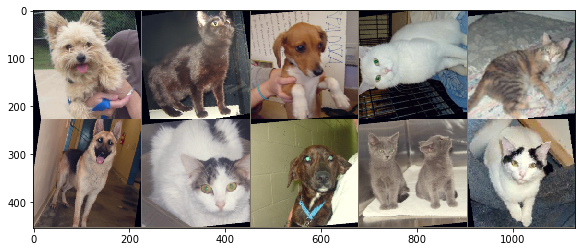

In [10]:
im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(
    #grab mean & divide by std and take the reciprocal of std
    mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std = [1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0))); #transpose the colour channel of matplotlib expects RGB to BGR


In [11]:
#define CNN model
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1) #3-input colour channel rgb,6-filters(random val),3-3x3 kernel size, stride of 1
        self.conv2 = nn.Conv2d(6,16,3,1)#6-inherited from conv1 filter,16-random increase of filter--larger=more training time,3 & 1 same as conv1
        #start reducing parameters using fully connected layers
        self.fc1 = nn.Linear(54*54*16,120) #((((224-2)/2)-2)/2) = 54 (224-2 coz lack of padding)
        self.fc2  = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2) # 2by2 kernel, stride 2
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1) #the final activation fn is not relu but log softmax coz we are performing technically multiclass classification (just 2 classes btw)
        
        

In [12]:
#setup loss & optimization fn
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)


In [13]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [14]:
#lets see how many parameters we have
for p in CNNmodel.parameters():
    print(p.numel()) #numel--number of element

162
6
864
16
5598720
120
10080
84
168
2


In [15]:
#PART 2 --> TRAINING AND EVALUATING MODEL

In [15]:
import time
start_time = time.time()


epochs = 3 #we should reach 70% accuracy after 3rd epochs which pretty good (random guess it would be 50%)

#LIMITS on num of batches
max_trn_batch = 800 # batch 10 images --> total 8k images 
max_tst_batch = 300 # total 3k images


train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader):
        
        #OPTIONAL LIMIT NUM OF BATCHES
        if b == max_trn_batch:
            break
            
        b += 1
        
        #get predicted image
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred,y_train)
        
        #TALLY THE NUMBER OF CORRECT PREDICTIONS
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() #True 1 /False 0 sum()
        trn_corr += batch_corr
        
        #update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #print report for every 200 batch
        if b%200 == 0:
            print(f'Epochs {i} LOSS: {loss.item()}')
            

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #TEST SET
    #MAKE SURE WE DON'T UPDATE WEIGHT AND BIASES WITH THE TEST SET!
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            #OPTIONAL LIMITING THE BATCH
            if b==max_tst_batch:
                break
            
            #grab predicted value
            y_val = CNNmodel(X_test)
            
            #see if we predicted corrrectly
            predicted = torch.max(y_pred.data,1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr = tst_corr + batch_corr
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time
print(f'Total time: {total_time/60} minutes')

Epochs 0 LOSS: 0.7072795629501343
Epochs 0 LOSS: 0.6907883882522583
Epochs 0 LOSS: 0.5377955436706543
Epochs 0 LOSS: 0.5495873093605042
Epochs 1 LOSS: 0.3166944980621338
Epochs 1 LOSS: 0.542432963848114
Epochs 1 LOSS: 0.8671501874923706
Epochs 1 LOSS: 0.381225049495697
Epochs 2 LOSS: 0.4282412528991699
Epochs 2 LOSS: 0.3217568099498749
Epochs 2 LOSS: 0.4526362419128418
Epochs 2 LOSS: 0.31658217310905457
Total time: 26.561153109868368 minutes


In [ ]:
#save model after training
torch.save(CNNmodel.state_dict(),'my3epochsCNNmodel.pt')

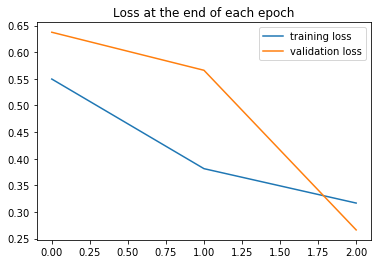

In [18]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [ ]:
#the validation & training loss decrease

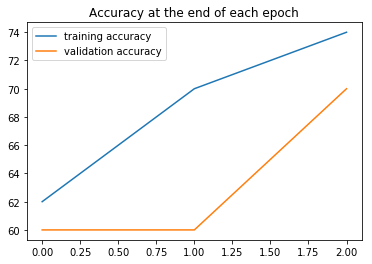

In [19]:
#ACCURACY
plt.plot([t/80 for t in train_correct],label='training accuracy')
plt.plot([t/30 for t in test_correct],label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [20]:
#accuracy increase over time--so this is good

In [20]:
#check how many we get correct
100*test_correct[-1].item()/3000

70.0

In [ ]:
#PART3----PRETRAINED NETWORK

In [21]:
#pretrained=True---download the pretrained weight
AlexNetmodel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\A221LPEN/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
100.0%


In [22]:
#call that defined model name to check whether it is downloaded, we should see the model architecture
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [23]:
#freeze certain feature parameter (pretrained weight and biases)

for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [ ]:
#recall this network was trained to classify 1k diff categories
#eventually we want to classify the variant 2 of them
#as written in the architecture above, it is separated by sequential object
#this sequential object can then create sequence of diff layers & activation layer fn
#classifier sequence is the one that we actually grab and edit

In [25]:
torch.manual_seed(42)

#grab the sequential of classifier series
#capture 1st input features as in architecture--9216, 1024 arbitrary, and lastly reduce it to 2

AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216,1024), 
                                        nn.ReLU(), 
                                        nn.Dropout(0.5), 
                                        nn.Linear(1024,2),
                                        nn.LogSoftmax(dim=1))


In [26]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [31]:
#count parameters
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [ ]:
#9437184
#1024
#2048
#2
#these 4 parameters that are going to be updating & changing

In [32]:
#we are holding instate all the convolutional stuff that AlexNet had been trained on
#we focus on the last series of fully connected layers
#to be able to leverage those filters that have already learn & trained
#then leverage that information in that pretraining to see if it works well on our images
#THAT IS WHY WE ONLY GRAB THE CLASSIFIER PARAMETERS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [29]:
#remember we only training the fully connected layer here

In [33]:
import time
start_time = time.time()

epochs = 1 #only 1 epoch coz Convolutional layer has fixed weight & biases

#OPTIONAL
max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 1.54910529  accuracy:  91.000%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00520250  accuracy:  91.525%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.52783161  accuracy:  92.250%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.10766526  accuracy:  92.287%

Duration: 555 seconds


In [34]:
#accuracy is good, so it means that the filters learned by Alexnet are applicable to our image


In [35]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2501)]
Test accuracy: 83.367%


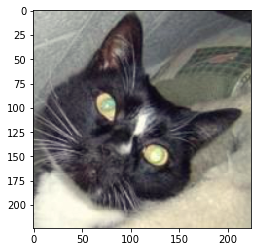

In [46]:
image_index =2022

im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [47]:
#test the selected image with CNN model that had been trained before
CNNmodel.eval()

with torch.no_grad():
    new_pred = CNNmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
    
class_names[new_pred.item()]

'CAT'

In [48]:
#test the selected image with AlexNet model 
AlexNetmodel.eval()

with torch.no_grad():
    new_pred = AlexNetmodel(test_data[image_index][0].view(1,3,224,224)).argmax()
    
class_names[new_pred.item()]

'CAT'